In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$F_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta^\top x$$

# Generate Communication Network

In [2]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

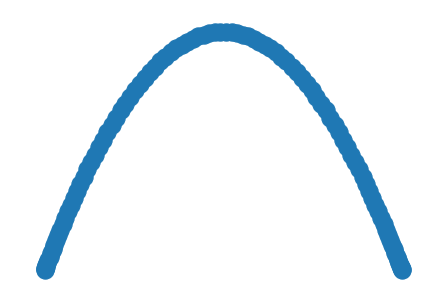

In [3]:
nx.draw_spectral(G)

# Problem Parameters

In [4]:
theta_0 = (1/(n+3))*np.ones((n,n))-np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
print(theta)
xi = n

[[-0.86752071 -0.10112483 -0.17283923 ... -0.10738393  0.01099571
   0.0769002 ]
 [-0.04244644 -0.86881981 -0.06105109 ... -0.14896225 -0.03277008
  -0.10080709]
 [ 0.21587474  0.07724019 -1.0170114  ...  0.03465825  0.01651364
   0.13084626]
 ...
 [ 0.07757992  0.00251736 -0.06797485 ... -1.10190278  0.02296526
  -0.11409735]
 [ 0.03712261 -0.01911717 -0.1853917  ... -0.10282936 -0.85270802
   0.05416709]
 [-0.07801168 -0.01633067  0.09874479 ... -0.0874907  -0.13828482
  -1.01247298]]


# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return 2*np.dot(theta,x) + xi

# Centralized GD

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 3096.21it/s]


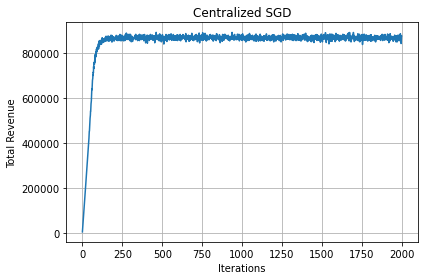

[ 82.80134926   0.         100.         100.         100.
   0.         100.         100.         100.         100.
  59.17294994 100.         100.         100.          86.92303518
 100.         100.         100.          93.31481832 100.
 100.          34.84051398 100.         100.           0.
 100.         100.         100.         100.         100.
  17.12385535   0.         100.         100.         100.
  42.33708533 100.         100.          94.77547532  11.99687901
  95.49021868   1.92553389   0.           9.96045756 100.
 100.          12.2384154  100.         100.         100.
 100.         100.         100.         100.          80.05222413
 100.         100.         100.          74.34876433 100.
 100.         100.          49.756407   100.         100.
 100.         100.         100.           0.         100.
  57.86681878 100.          43.2144397   39.48227165 100.
 100.           0.          94.43421311 100.         100.
 100.          12.24349992 100.          38.7600

In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
p_max = n  # Set maximum price
rev = []
x_hist = []
iterations = 2000

# Run centralized GD
for i in trange(iterations):
    xi = n+np.random.randn(1)
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    x = np.clip(x,0,p_max)
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.title('Centralized SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/central_sgd.png')
plt.show()

print(x)

In [7]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

# Distributed SGD with synchronous information

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.33it/s]


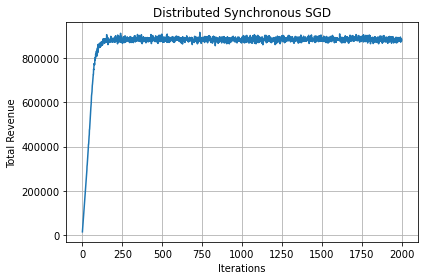

[ 82.80138045   0.         100.         100.         100.
   0.         100.         100.         100.         100.
  59.1712358  100.         100.         100.          86.90680186
 100.         100.         100.          93.30966994 100.
 100.          34.82238928 100.         100.           0.
 100.         100.         100.         100.         100.
  17.1174224    0.         100.         100.         100.
  42.33791192 100.         100.          94.7633422   11.98506642
  95.48576878   1.91636036   0.           9.95079197 100.
 100.          12.21291949 100.         100.         100.
 100.         100.         100.         100.          80.03814426
 100.         100.         100.          74.33627998 100.
 100.         100.          49.73551449 100.         100.
 100.         100.         100.           0.         100.
  57.85968109 100.          43.19689677  39.47375037 100.
 100.           0.          94.42819356 100.         100.
 100.          12.22988788 100.          38.7653

In [8]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_cent = []
x_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    x_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        X[j] += step*grad_revenue(X[j],theta,xi)
        temp.append(total_revenue(X[j],theta,xi))
    rev_cent.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_cent)
plt.grid()
plt.title('Distributed Synchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_sync.png')
plt.show()

print(np.mean(X,axis=0))

In [9]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

In [10]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.0037797893731988767


# Distributed SGD with asynchronous information

100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.61it/s]


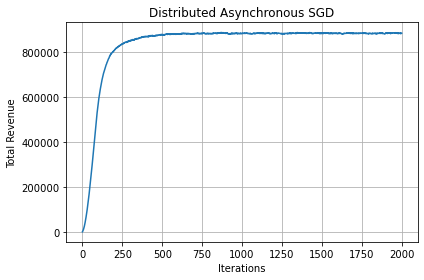

[ 82.87229013   0.         100.         100.         100.
   0.         100.         100.         100.         100.
  59.24257207 100.         100.         100.          86.9455078
 100.         100.         100.          93.37287837 100.
 100.          34.85822422 100.         100.           0.
 100.         100.         100.         100.         100.
  17.16645512   0.         100.         100.         100.
  42.42104279 100.         100.          94.81872516  12.03367307
  95.55866772   1.97096275   0.          10.00679118 100.
 100.          12.24839783 100.         100.         100.
 100.         100.         100.         100.          80.10046873
 100.         100.         100.          74.39435732 100.
 100.         100.          49.77888736 100.         100.
 100.         100.         100.           0.         100.
  57.92278362 100.          43.23869149  39.53813751 100.
 100.           0.          94.50159353 100.         100.
 100.          12.27935363 100.          38.85835

In [11]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_async.png')
plt.show()

print(np.mean(X,axis=0))

In [12]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.08146294364536782


# Fully connected graph

100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.22it/s]


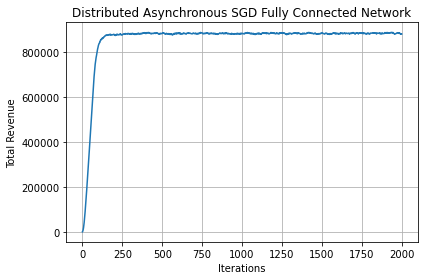

[ 82.91568609   0.         100.         100.         100.
   0.         100.         100.         100.         100.
  59.28218985 100.         100.         100.          86.94020692
 100.         100.         100.          93.40605839 100.
 100.          34.84372529 100.         100.           0.
 100.         100.         100.         100.         100.
  17.20238971   0.         100.         100.         100.
  42.46409163 100.         100.          94.818194    12.04562524
  95.60235309   1.98283678   0.          10.0330266  100.
 100.          12.20112921 100.         100.         100.
 100.         100.         100.         100.          80.09666871
 100.         100.         100.          74.3821734  100.
 100.         100.          49.74473681 100.         100.
 100.         100.         100.           0.         100.
  57.94321678 100.          43.21456571  39.55749583 100.
 100.           0.          94.51370917 100.         100.
 100.          12.26433854 100.          38.9079

In [13]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.erdos_renyi_graph(n,0.2)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Fully Connected Network')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_fc.png')
plt.show()

print(np.mean(X,axis=0))

In [14]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.16997823483962918


# Erdos Renyi random graph p=0.2

100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.64it/s]


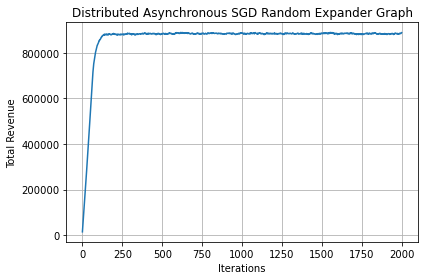

[ 82.78597939   0.         100.         100.         100.
   0.         100.         100.         100.         100.
  59.16161002 100.         100.         100.          86.93637028
 100.         100.         100.          93.30420005 100.
 100.          34.86041706 100.         100.           0.
 100.         100.         100.         100.         100.
  17.10546639   0.         100.         100.         100.
  42.32763725 100.         100.          94.79144932  11.99885489
  95.47477512   1.93065431   0.           9.95261651 100.
 100.          12.28674044 100.         100.         100.
 100.         100.         100.         100.          80.07438164
 100.         100.         100.          74.37675966 100.
 100.         100.          49.79631688 100.         100.
 100.         100.         100.           0.         100.
  57.86772002 100.          43.24591766  39.48507596 100.
 100.           0.          94.44741632 100.         100.
 100.          12.27023925 100.          38.7491

In [15]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Random Expander Graph')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_expander.png')
plt.show()

print(np.mean(X,axis=0))

In [16]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.010394008942123072
